In [15]:
import cv2 as cv
import cv2
import numpy as np
import math
import glob
import os
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k = 0
Result = []
for img in glob.glob("C:/Users/Frederik/Desktop/123/*.tif"): #папка исходных фотографий
    img = cv2.imread(img) #считывание фотографии
    cv2.imwrite(os.path.join("C:/Users/Frederik/Desktop/Init/" , 'img'+str(k)+'.jpg'), img) #сохранение фотографии в виде, указанном в отчете
    hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV) # перевод цветного изображения в черно-белый
    lower = np.array([0, 0, 45], dtype = "uint8") # определение нижних границ бинаризации
    upper = np.array([200, 255, 255], dtype = "uint8") # определение верхних границ бинаризации

    skinRegionHSV = cv.inRange(hsvim, lower, upper) # бинаризация изображения для отделения фона


    blurred = cv.blur(skinRegionHSV,(1,1)) # применение сглаживания
    ret,thresh = cv.threshold(blurred,0,255,cv.THRESH_BINARY) # применение бинаризации

    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) # поиск контуров
    contours = max(contours, key=lambda x: cv.contourArea(x)) # поиск самого большого контура, описывающего руку
 
    hull = cv.convexHull(contours, returnPoints=False) # определение внешней ломаной 
    defects = cv.convexityDefects(contours, hull)  # определение внутренней ломаной 

    starts = [] # массив точек начал ломаных линиий
    ends = [] # массив точек середин ломаных линиий
    fars = [] # массив точек конца ломаных линиий

    for i in range(defects.shape[0]):  # подсчет угла между пальцами с помощью теоремы косинусов
        s, e, f, d = defects[i][0]
        start = tuple(contours[s][0])
        end = tuple(contours[e][0])
        far = tuple(contours[f][0])
        a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
        c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
        angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))  
        if angle <= np.pi / 2:   # определение ломаной в качестве пальца, если угол меньше 90 градусов
            starts.append(start) # запись соответствующих точек в массивы
            ends.append(end)
            fars.append(far)

    for i in range(len(starts)): # замыкание точек на подушечках пальцев
        for j in range(len(starts)):
            if 50 > math.dist(starts[i], ends[j]) > 0 and i != j:
                q = ((starts[i][0] + ends[j][0]) // 2, (starts[i][1] + ends[j][1]) // 2)
                starts[i] = q
                ends[j] = q

    while len(starts) > 4: # исключения из рассмотрения "лишних" пальцев, если они были найдены
        w = starts.index(max(starts, key = lambda x: x[1]))
        starts.pop(w)
        ends.pop(w)
        fars.pop(w)

    for i in range(len(starts)): # изображение результатов на исходном изображении
        cv.line(img,starts[i],fars[i],(0,255,0),2)
        cv.line(img,fars[i],ends[i],(0,255,0),2)

        cv.circle(img, fars[i], 7, [0, 255, 0], -1)
        cv.circle(img, starts[i], 7, [0, 255, 0], -1)
        cv.circle(img, ends[i], 7, [0, 255, 0], -1)

        cv.circle(img, fars[i], 5, [255, 255, 255], -1)
        cv.circle(img, starts[i], 5, [255, 255, 255], -1)
        cv.circle(img, ends[i], 5, [255, 255, 255], -1)


    ars = [] # подсчет значений для определения форм
    brs = []
    crs = []
    ans = []
    for i in range(len(starts)):
        start = starts[i]
        end = ends[i]
        far = fars[i]
        a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
        c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
        angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))
        ars.append(a)
        brs.append(b)
        crs.append(c)
        ans.append(angle)
    Result.append(ars + brs + crs + ans) # записывание значений в результирующий массив со всеми значениями вех изображений

    cv2.imwrite(os.path.join("C:/Users/Frederik/Desktop/Res/" , 'img'+str(k)+'.jpg'), img) # сохранение измененного изображения
    k += 1

In [2]:
for i in Result: # одна фотография была, к сожалению, подпорчена, поэтому применяется дозаполнение неполных массивов нулями
    for j in range(len(i),16):
        i.append(0)

Dists = [] # подсчет расстояний между точками в 16-мерном пространстве
for i in range(len(Result)):
    temp = []
    for j in Result:
        temp.append(np.linalg.norm(np.array(Result[i]) - np.array(j)))
    temp[i] = 10000
    Dists.append(temp)

In [3]:
np.array(Dists).view(type=np.matrix) # матрица полученных расстояний

matrix([[10000.        ,    61.2787923 ,   249.45868799, ...,
           290.58195657,    82.65212299,   227.8714376 ],
        [   61.2787923 , 10000.        ,   225.29908553, ...,
           265.4657319 ,    75.34019926,   216.20191899],
        [  249.45868799,   225.29908553, 10000.        , ...,
           264.21132135,   203.59885021,   243.47429719],
        ...,
        [  290.58195657,   265.4657319 ,   264.21132135, ...,
         10000.        ,   259.91072927,   253.06429197],
        [   82.65212299,    75.34019926,   203.59885021, ...,
           259.91072927, 10000.        ,   180.50419524],
        [  227.8714376 ,   216.20191899,   243.47429719, ...,
           253.06429197,   180.50419524, 10000.        ]])

In [4]:
wri = [] # определение ближайших соседей
for i in range(len(Dists)):
    a = np.argpartition(Dists[i], 3)
    temp = [i]
    for j in range(3):
        temp.append(a[j])
    wri.append(temp)

In [5]:
array = wri # запись данных в таблицу
df = pd.DataFrame(array)
df.to_excel(excel_writer = "C:/Users/Frederik/Desktop/Top3.xlsx")

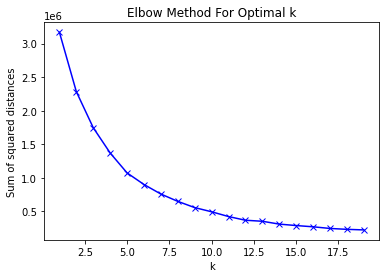

In [6]:
Sum_of_squared_distances = [] # поиск оптимального числа кластеров
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Result)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [11]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(Result) # применение кластеризации

In [12]:
mydict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}


dictlist = []
for key, value in mydict.items():
    temp = [value]
    dictlist.append(temp)
dictlist # кластеризированные значения

[[array([18, 21, 22, 23, 25, 31, 35, 39, 41, 45, 50, 51, 60, 64, 75, 80, 82,
         83, 84, 85, 86, 90], dtype=int64)],
 [array([20, 30, 37, 44, 46, 47, 55, 56, 61, 67, 70, 71, 77, 98],
        dtype=int64)],
 [array([33, 53], dtype=int64)],
 [array([ 3,  8, 38, 59, 62, 66, 87, 95, 96], dtype=int64)],
 [array([ 2,  5,  7, 10, 24, 26, 27, 40, 42, 43, 49, 54, 65, 68, 76, 78, 81],
        dtype=int64)],
 [array([63, 74], dtype=int64)],
 [array([29], dtype=int64)],
 [array([48, 72, 89, 92], dtype=int64)],
 [array([ 0,  1,  4,  6,  9, 11, 12, 13, 14, 15, 16, 17, 19, 28, 32, 34, 36,
         52, 57, 58, 69, 79, 88, 91, 93, 94, 97], dtype=int64)],
 [array([73], dtype=int64)]]

In [13]:
array = dictlist # сохранение кластеризированныХ значений в таблицу
df = pd.DataFrame(array)
df.to_excel(excel_writer = "C:/Users/Frederik/Desktop/Persons.xlsx")